### <center>**Reading and Cleaning Annotation Data for Custom PyTorch Object Detection**</center> 

In [1]:
from IPython import get_ipython

ipython = get_ipython()
if ipython is not None:
    ipython.cache_size = 0  # disable cache

In [2]:
# Import necessary packages
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # restrict cuda to gpu 0
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # set CUDA kernel to synchronous
import json
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion(); # interactive mode

##### Load annotation data into dataframe

In [3]:
# Function for reading JSON as dictionary
def read_json(filename: str) -> dict:
    try:
        with open(filename, "r") as f:
            data = json.load(f)
    except Exception as e:
        raise Exception(f"Reading {filename} file encountered an error: {e}")
    return data

# Function to create a DataFrame from a list of records
def create_dataframe(data: list) -> pd.DataFrame:
    # Normalize the column levels and create a DataFrame
    return pd.json_normalize(data)

# Main function to iterate over files in directory and add to df
def main():
    # Assign directory and empty list for collecting records
    directory = "C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/"  # annotation directory
    records = []
    
    # Iterate over files in directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            # Read the JSON file as python dictionary 
            data = read_json(filename=f)
        
            # Create the dataframe for the array items in annotations key 
            df = create_dataframe(data=data['annotations'])
            df.insert(loc=0, column='img_name', value=f'{f[-30:-5]}.JPG')
        
            df.rename(columns={
                "img_name": "img_name",
                "name": "label",
                "bounding_box.h": "bbox_height",
                "bounding_box.w": "bbox_width",
                "bounding_box.x": "bbox_x_topLeft",
                "bounding_box.y": "bbox_y_topLeft",
                "polygon.paths": "polygon_path"
            }, inplace=True)
            
            # Append the records to the list
            records.append(df)
        else:
            print(f"Skipping non-file: {filename}")

    # Concatenate all records into a single DataFrame
    annos_df = pd.concat(records, ignore_index=True)

    # Convert x, y, h, w to xmin, ymin, xmax, ymax
    annos_df['xmin'] = annos_df['bbox_x_topLeft']
    annos_df['ymin'] = annos_df['bbox_y_topLeft']
    annos_df['xmax'] = annos_df['bbox_x_topLeft'] + annos_df['bbox_width']
    annos_df['ymax'] = annos_df['bbox_y_topLeft'] + annos_df['bbox_height']
  
    # Drop unnecessary columns 
    annos_df = annos_df.drop(columns=['bbox_height', 'bbox_width', 'bbox_x_topLeft', 
                                      'bbox_y_topLeft', 'id', 'slot_names', 'polygon_path'])
        
    return annos_df

if __name__ == "__main__":
    df = main()
    print(df.head())

                        img_name label     xmin     ymin     xmax     ymax
0  DJI_20211215103949_0003_Z.JPG   Hen   626.35  1538.24  1249.31  1924.61
1  DJI_20211215103949_0003_Z.JPG  MALL  2083.69  1894.40  2770.84  2339.91
2  DJI_20211215103957_0004_Z.JPG  MALL  2779.02  1336.17  3263.37  2020.32
3  DJI_20211215103957_0004_Z.JPG   Hen  1734.63  1649.99  2547.94  1978.95
4  DJI_20211215105707_0002_Z.JPG   Hen  2677.59  1822.57  3072.69  2188.04


##### Pre-process annotation dataframe

In [4]:
# Get the unique image names
unique_img_names = df['img_name'].unique()

invalid_img_names = []
for img_name in unique_img_names:
    img_path = f'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Images/{img_name}'
    img = Image.open(img_path)
    if img.size == (5184, 3888):
        invalid_img_names.append(img_name)

# remove invalid images from df
df = df[~df['img_name'].isin(invalid_img_names)]

img_classes_to_remove = ['WTDE', 'TURT', 'NUTR', 'ANHI', 'CAGO', 
                         'DCCO', 'GWFG', 'GBHE', 'COGA', 'PBGR'] # remove images with these classes

for class_label in img_classes_to_remove:
    # Get all image names with the class
    images_with_class = df[df['label'] == class_label]['img_name'].unique()

    # Remove all rows for img
    df = df[~df['img_name'].isin(images_with_class)]

# remove images containing only hens
hen_images_no_other_class = df[(df['label'] == 'Hen') & (~df['img_name'].isin(df[df['label'] != 'Hen']['img_name']))]['img_name'].unique()
df = df[~df['img_name'].isin(hen_images_no_other_class)]

# Separate classes with less than 50 instances
class_counts = df['label'].value_counts()
other_classes = class_counts[class_counts < 50].index.tolist()
positive_classes = class_counts[class_counts >= 50].index.tolist()

# print class counts for each label
print("Number of instances per class in cleaned dataset:")
for label in df['label'].unique():
    print(f'{label}: {len(df[df["label"] == label])}')

# print other and positive classes
print()
print(f'Other classes: {other_classes}')
print(f'Positive classes: {positive_classes}')

# remove images with other classes
for class_label in other_classes:
    # Get all image names with the class
    images_with_class = df[df['label'] == class_label]['img_name'].unique()

    # Remove all rows for img
    df = df[~df['img_name'].isin(images_with_class)]

# confirm the only classes in df are positive classes
assert len(df['label'].unique()) == len(positive_classes)

# encode labels as int (reserve 0 for 'background')
df['target'] = pd.Categorical(df['label']).codes + 1

# filter out images with invalid bounding boxes
df = df.groupby('img_name').filter(lambda x: ((x['xmin'] < x['xmax']) & (x['ymin'] < x['ymax'])).all())

# Create a dictionary using df['label'] as the keys and df['target'] as the values
label_dict = dict(zip(df['target'], df['label']))

# Drop the original 'label' column from df
df = df.drop(['label'], axis=1)

# Rename 'target' column to 'label'
df.rename(columns={'target': 'label'}, inplace=True)

# Save df as csv in directory
df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv', index=False)

Number of instances per class in cleaned dataset:
Hen: 3351
MALL: 1181
WODU: 15
HOME: 2
NSHO: 558
AMCO: 631
GWTE: 856
GADW: 1207
RNDU: 1531
BWTE: 4
NOPI: 771
AMWI: 57
REDH: 268
LESC: 28
CANV: 8
BUFF: 99

Other classes: ['LESC', 'WODU', 'CANV', 'BWTE', 'HOME']
Positive classes: ['Hen', 'RNDU', 'GADW', 'MALL', 'GWTE', 'NOPI', 'AMCO', 'NSHO', 'REDH', 'BUFF', 'AMWI']


##### Filter images after pre-processing

In [5]:
# Store unique img_names in filtered df as array
img_names = df['img_name'].unique().tolist()

# Create a new directory called 'filtered_images'
new_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
else:
    for file in os.listdir(new_dir):
        os.remove(os.path.join(new_dir, file))

# Copy images in img_names to new directory
for img in img_names:
    shutil.copy2(f'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Images/{img}', new_dir)

### <center>**Transform and Augment Image and Annotation Data for Custom PyTorch Object Detection**</center> 

In [6]:
# import necessary packages
import numpy as np
from collections import defaultdict, Counter
import torchvision
torchvision.disable_beta_transforms_warning()
import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
from torchvision import transforms as _transforms, tv_tensors
import torchvision.transforms.v2 as T
import utils

In [7]:
class MAVdroneDataset(torch.utils.data.Dataset):
    """Dataset Loader for Waterfowl Drone Imagery"""

    def __init__(self, csv_file, root_dir, transforms):
        """
        Arguments:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory containing all images.
            transforms (callable): Transformation to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transforms = transforms
        self.unique_image_names = self.df['img_name'].unique()

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = self.unique_image_names[idx]

        # Isolate first row to prevent multiple instances of the same image
        row = self.df[self.df['img_name'] == image_name].iloc[0]

        image_path = os.path.join(self.root_dir, row['img_name'])

        image = Image.open(image_path).convert('RGB')

        image = np.array(image, dtype=np.uint8)

        image = torch.from_numpy(image).permute(2, 0, 1)  # Convert to Tensor

        # Bounding boxes and labels
        boxes = self.df[self.df['img_name'] == image_name][['xmin', 'ymin', 'xmax', 'ymax']].values 
        labels = self.df[self.df['img_name'] == image_name]['label'].values

        labels = torch.as_tensor(labels, dtype=torch.int64)  # (n_objects)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Calculate area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Assume no crowd annotations
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        # Create target dictionary
        target = {
            'boxes': tv_tensors.BoundingBoxes(boxes, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=(image.shape[1], image.shape[2])),
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.unique_image_names)

##### Data transformation function

In [8]:
def get_transform(train: bool): 
    """
    Args:
        train (bool): Whether the transform is for training or validation/testing.
    """
    transforms_list = []
    transforms_list.append(T.ToImage())
    if train:
        transforms_list.append(T.RandomApply([T.RandomRotation(degrees=[-5, 5], fill=defaultdict(lambda: 0, {tv_tensors.Image: (0, 0, 0)}))], p=0.5)) # black fill
        transforms_list.append(T.RandomHorizontalFlip(0.5))
        # transforms_list.append(T.RandomIoUCrop(min_scale = 0.8, max_scale = 1.1)) # values less than one "zoom-in" the image
        transforms_list.append(T.RandomApply([T.ColorJitter(brightness=0.05, contrast=0.15, saturation=0.05, hue=0)], p=0.5))
    transforms_list.append(T.Resize(size=(810,), max_size=1440, interpolation=torchvision.transforms.InterpolationMode.BICUBIC))
    transforms_list.append(T.ClampBoundingBoxes()) # Clamp bounding boxes to image boundaries
    transforms_list.append(T.SanitizeBoundingBoxes(min_area=5, min_size=1))
    transforms_list.append(T.ToDtype(dtype = torch.float32, scale = True)) # Converts image to [0, 1] range
    transforms_list.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])) 
    return T.Compose(transforms_list)

##### Helper functions for plotting image and annotations

In [9]:
# classes are values in label_dict
classes = list(label_dict.values())

# reverse label dictionary for mapping predictions to classes
rev_label_dict = {v: k for k, v in label_dict.items()}

# distinct colors 
bbox_colors = [
    "#FF0000",  # Red
    "#00FF00",  # Green
    "#0000FF",  # Blue
    "#FFFF00",  # Yellow
    "#FF00FF",  # Magenta
    "#00FFFF",  # Cyan
    "#FFC0CB",  # Pink
    "#FFA500",  # Orange
    "#800080",  # Purple
    "#FFFFFF",  # White
    "#FFD700",  # Gold
    "#000000"   # Black
]

# label color map for plotting color-coded boxes by class
label_color_map = {k: bbox_colors[i] for i, k in enumerate(label_dict.keys())}

# function for reshaping boxes 
def get_box(boxes):
    boxes = np.array(boxes)
    boxes = boxes.astype('float').reshape(-1, 4)
    if boxes.shape[0] == 1 : return boxes
    return np.squeeze(boxes)


# function for plotting image
def img_show(image, ax = None, figsize = (6, 9)):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    ax.xaxis.tick_top()
    ax.imshow(image)
    return ax
 

def plot_bbox(ax, boxes, labels):
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    # add label text to bounding box using label_dict if label exists else labels
    ax.text(boxes[:, 2], boxes[:, 3], 
            (label_dict[labels.item()] if labels.item() in label_dict else labels.item()),
            fontsize = 8,
            bbox = dict(facecolor = 'white', alpha = 0.8, pad = 0, edgecolor = 'none'),
            color = 'black')


# function for plotting all boxes and labels on the image using get_polygon, img_show, and plot_mask functions
def plot_detections(image, boxes, labels, ax = None):
    ax = img_show(image.permute(1, 2, 0), ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox(ax, box, labels[i])

##### Plot sample batch to confirm data loads and transforms correctly

In [10]:
# Load sample batch of data to custom PyTorch Dataset and Transform
sample_dataset = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv', 
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images', 
                                transforms = get_transform(train = True))

sample_data_loader = torch.utils.data.DataLoader(sample_dataset, batch_size = 8, shuffle=True, 
                                                collate_fn = utils.collate_fn, num_workers = 0)

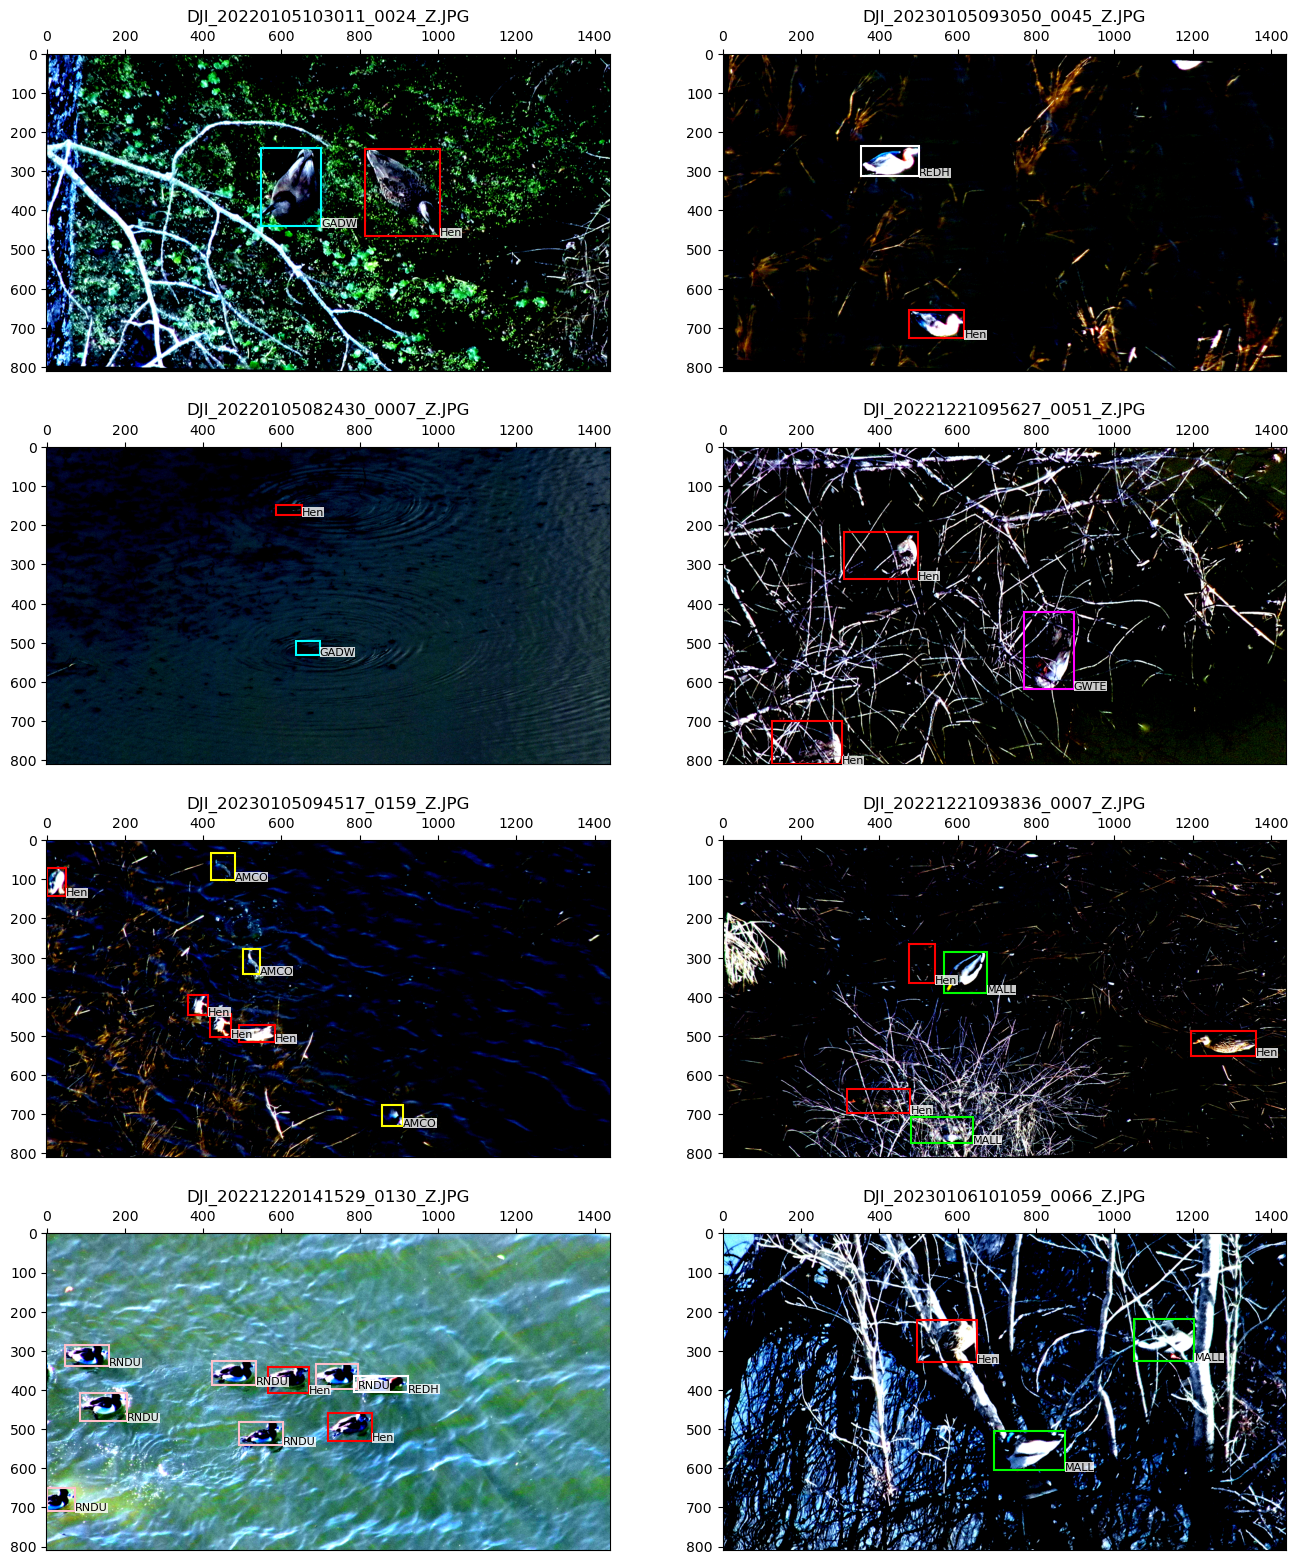

In [11]:
# store images and annotation targets from sample batch
batch = next(iter(sample_data_loader))
images, targets = batch
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

images = [np.clip(image, 0, 1) for image in images]

# Plot all samples from batch in a grid of subplots
plt.figure(figsize=(16, int(sample_data_loader.batch_size) * 5))
for i in range(int(sample_data_loader.batch_size)):
    ax = plt.subplot(int(sample_data_loader.batch_size), 2, 1 + i)
    plot_detections(images[i], targets[i]['boxes'], targets[i]['labels'], ax=ax)
    # Query the dataset to get the image name for the given image_id
    image_id = targets[i]['image_id'].item()  # Convert tensor to integer
    image_name = sample_dataset.unique_image_names[image_id]
    plt.title(image_name)

plt.show()

#### Use stratified sampling to split multi-label dataset into train, val, test sets

In [12]:
from sklearn.model_selection import StratifiedKFold

# Set random number generator for reproducible data splits
rng = np.random.default_rng(np.random.MT19937(np.random.SeedSequence(420)))

# Group annotations by image
image_groups = df.groupby('img_name')

# Create a dictionary to store the class distribution for each image
image_class_distribution = {}

# Populate the dictionary with class distributions
for image_name, group in image_groups:
    labels = group['label'].tolist()
    image_class_distribution[image_name] = labels

# Create a list of all image names and their corresponding labels
all_images = list(image_class_distribution.keys())
all_labels = [image_class_distribution[image] for image in all_images]

# Use the most frequent label for each image for stratification
representative_labels = [max(set(labels), key=labels.count) for labels in all_labels]

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.15
test_ratio = 0.05

# Perform stratified split using StratifiedKFold
skf = StratifiedKFold(n_splits=int(1/test_ratio), shuffle=True, random_state=420)

train_val_indices, test_indices = next(skf.split(all_images, representative_labels))

# Further split train+val into train and validation sets
train_val_images = [all_images[idx] for idx in train_val_indices]
train_val_labels = [representative_labels[idx] for idx in train_val_indices]

skf_val = StratifiedKFold(n_splits=int(1/(val_ratio/(train_ratio + val_ratio))), shuffle=True, random_state=420)
train_indices, val_indices = next(skf_val.split(train_val_images, train_val_labels))

# Map image names to unique indices
image_to_unique_index = {image: idx for idx, image in enumerate(df['img_name'].unique())}

# Create lists of unique indices for each split
train_indices = [image_to_unique_index[train_val_images[idx]] for idx in train_indices]
val_indices = [image_to_unique_index[train_val_images[idx]] for idx in val_indices]
test_indices = [image_to_unique_index[all_images[idx]] for idx in test_indices]

# Function to get class distribution
def get_class_distribution(images, image_class_distribution):
    class_counts = defaultdict(int)
    for image in images:
        for label in image_class_distribution[image]:
            class_counts[label] += 1
    return class_counts

# Get train, val, and test images
train_images = [all_images[idx] for idx in train_indices]
val_images = [all_images[idx] for idx in val_indices]
test_images = [all_images[idx] for idx in test_indices]

train_class_distribution = get_class_distribution(train_images, image_class_distribution)
val_class_distribution = get_class_distribution(val_images, image_class_distribution)
test_class_distribution = get_class_distribution(test_images, image_class_distribution)

class_indices = {label: [] for label in df['label'].unique()}

for idx, row in df.iterrows():
    class_indices[row['label']].append(idx)

train_class_distribution = {k: v / len(class_indices[k]) for k, v in train_class_distribution.items()}
val_class_distribution = {k: v / len(class_indices[k]) for k, v in val_class_distribution.items()}
test_class_distribution = {k: v / len(class_indices[k]) for k, v in test_class_distribution.items()}

print("Train class distribution:", dict(sorted(train_class_distribution.items())))
print("Validation class distribution:", dict(sorted(val_class_distribution.items())))
print("Test class distribution:", dict(sorted(test_class_distribution.items())))

Train class distribution: {1: 0.7746031746031746, 2: 0.7090909090909091, 3: 0.7373737373737373, 4: 0.7980049875311721, 5: 0.7710280373831776, 6: 0.7936360827927093, 7: 0.806615776081425, 8: 0.7945383615084526, 9: 0.8288288288288288, 10: 0.8293650793650794, 11: 0.7940983606557377}
Validation class distribution: {1: 0.16984126984126985, 2: 0.2545454545454545, 3: 0.21212121212121213, 4: 0.16375727348295926, 5: 0.1822429906542056, 6: 0.1600247142415817, 7: 0.13910093299406276, 8: 0.15214564369310793, 9: 0.12252252252252252, 10: 0.13095238095238096, 11: 0.1580327868852459}
Test class distribution: {1: 0.05555555555555555, 2: 0.03636363636363636, 3: 0.050505050505050504, 4: 0.038237738985868665, 5: 0.04672897196261682, 6: 0.04633920296570899, 7: 0.0542832909245123, 8: 0.053315994798439535, 9: 0.04864864864864865, 10: 0.03968253968253968, 11: 0.04786885245901639}


#### Create weighted random sampler to handle class imbalances during training

In [13]:
# Function to calculate class weights dynamically
def calculate_class_weights(labels, hen_label_int, background_label_int):
    # Count the occurrences of each class
    class_counts = Counter(labels)
    
    # Remove the "Hen" class from the counts
    hen_count = class_counts.pop(hen_label_int, None)
    
    # Identify the count for the second most-frequent class
    second_most_frequent_class_count = max(class_counts.values())
    
    # Calculate the weight for the "Hen" class
    hen_weight = second_most_frequent_class_count / hen_count if hen_count else 1.0
    
    # Assign weights to all classes
    class_weights = {label: sum(class_counts.values()) / count for label, count in class_counts.items()}
    
    # Normalize weights to range [1, 2]
    min_weight = min(class_weights.values())
    max_weight = max(class_weights.values())
    class_weights = {label: 1 + (weight - min_weight) / (max_weight - min_weight) for label, weight in class_weights.items()}
    
    # Add weight for the "Hen" class
    class_weights[hen_label_int] = hen_weight

    # Add weight = 5% for the background class
    class_weights[background_label_int] = 0.05
    
    return class_weights

# Store train labels for each image
train_labels = [label for image in train_images for label in image_class_distribution[image]]

# Calculate class weights dynamically
hen_label_int = [key for key, value in label_dict.items() if value == 'Hen'][0]  # Get the integer label for "Hen"
background_label_int = 0  # Assuming background is class 0
class_weights = calculate_class_weights(train_labels, hen_label_int, background_label_int)

# Convert class weights to a list in the correct order
unique_labels = sorted(set(train_labels))
train_class_weights = [class_weights[label] for label in unique_labels]

# Add weight for the background class
train_class_weights = [class_weights[background_label_int]] + train_class_weights  # Background is class 0
train_class_weights = torch.tensor(train_class_weights, dtype=torch.float32)

# print class counts and class weight for each class
print("Train class instances and weights: ")
for label in unique_labels:
    print(f"{label_dict[label]}: count = {train_labels.count(label)}, weight = {train_class_weights[label]}")


# Calculate sample weights for each image in the training dataset
train_sample_weights = []
for image_name in train_images:
    labels = image_class_distribution[image_name]
    sample_weight = sum(train_class_weights[label] for label in labels) / len(labels)
    train_sample_weights.append(sample_weight)

# print min and max train sample weights
print("Minimum sample weight:", min(train_sample_weights))
print("Maximum sample weight:", max(train_sample_weights))

# Create WeightedRandomSampler
train_sampler = torch.utils.data.WeightedRandomSampler(weights=train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

Train class instances and weights: 
AMCO: count = 488, weight = 1.049301028251648
AMWI: count = 39, weight = 2.0
BUFF: count = 73, weight = 1.5187479257583618
GADW: count = 960, weight = 1.0087003707885742
GWTE: count = 660, weight = 1.0277807712554932
Hen: count = 2569, weight = 0.47138965129852295
MALL: count = 951, weight = 1.009097695350647
NOPI: count = 611, weight = 1.032677412033081
NSHO: count = 460, weight = 1.054327368736267
REDH: count = 209, weight = 1.1595358848571777
RNDU: count = 1211, weight = 1.0
Minimum sample weight: tensor(0.5362)
Maximum sample weight: tensor(2.)


#### Configure Custom RetinaNet with ResNet FPN

In [22]:
import torch
import torch.nn as nn
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.retinanet import RetinaNetClassificationHead, RetinaNetRegressionHead
from torchvision.models.detection.anchor_utils import AnchorGenerator
from typing import Optional, Callable, List
from torchvision.ops import sigmoid_focal_loss, FrozenBatchNorm2d

def _sum(x: List[torch.Tensor]) -> torch.Tensor:
    res = x[0]
    for i in x[1:]:
        res = res + i
    return res

class CustomRetinaNetClassificationHead(RetinaNetClassificationHead):
    def __init__(self, in_channels, num_anchors, num_classes, alpha=0.25, gamma_loss=2.0, prior_probability=0.01, norm_layer: Optional[Callable[..., nn.Module]] = None, dropout_prob=0.25, class_weights=None):
        super().__init__(in_channels, num_anchors, num_classes, prior_probability, norm_layer)
        self.alpha = alpha
        self.gamma_loss = gamma_loss
        self.dropout = nn.Dropout(p=dropout_prob)
        self.class_weights = class_weights

    def compute_loss(self, targets, head_outputs, matched_idxs):
        losses = []

        cls_logits = head_outputs["cls_logits"]

        for i, (targets_per_image, cls_logits_per_image, matched_idxs_per_image) in enumerate(zip(targets, cls_logits, matched_idxs)):
            # determine only the foreground
            foreground_idxs_per_image = matched_idxs_per_image >= 0
            num_foreground = foreground_idxs_per_image.sum()

            # create the target classification
            gt_classes_target = torch.zeros_like(cls_logits_per_image)
            gt_classes_target[
                foreground_idxs_per_image,
                targets_per_image["labels"][matched_idxs_per_image[foreground_idxs_per_image]],
            ] = 1.0

            # find indices for which anchors should be ignored
            valid_idxs_per_image = matched_idxs_per_image != self.BETWEEN_THRESHOLDS

            # get the class weights for the valid indices
            if self.class_weights is not None:
                valid_labels = targets_per_image["labels"][matched_idxs_per_image[valid_idxs_per_image]]
                weights = self.class_weights.to(valid_labels.device)[valid_labels]
            else:
                weights = torch.ones_like(valid_idxs_per_image, dtype=torch.float32)

            # compute the classification loss with custom alpha, gamma_loss, and class weights
            losses.append(
                (sigmoid_focal_loss(
                    cls_logits_per_image[valid_idxs_per_image],
                    gt_classes_target[valid_idxs_per_image],
                    alpha=self.alpha,
                    gamma=self.gamma_loss,
                    reduction="none",
                ) * weights.unsqueeze(1)).sum() / max(1, num_foreground)
            )

        return _sum(losses) / len(targets)
    
    def forward(self, x):
        all_cls_logits = []
        for features in x:
            cls_logits = self.conv(features)
            cls_logits = self.dropout(cls_logits)  # Apply dropout
            cls_logits = self.cls_logits(cls_logits)

            # Permute classification output from (N, A * K, H, W) to (N, HWA, K).
            N, _, H, W = cls_logits.shape
            cls_logits = cls_logits.view(N, -1, self.num_classes, H, W)
            cls_logits = cls_logits.permute(0, 3, 4, 1, 2)
            cls_logits = cls_logits.reshape(N, -1, self.num_classes)  # Size=(N, HWA, K)

            all_cls_logits.append(cls_logits)


        return torch.cat(all_cls_logits, dim=1)

class CustomRetinaNetRegressionHead(RetinaNetRegressionHead):
    def __init__(self, in_channels, num_anchors, norm_layer: Optional[Callable[..., nn.Module]] = None, dropout_prob=0.25):
        super().__init__(in_channels, num_anchors, norm_layer)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        all_bbox_regression = []
        for features in x:
            bbox_regression = self.conv(features)
            bbox_regression = self.dropout(bbox_regression)  # Apply dropout
            bbox_regression = self.bbox_reg(bbox_regression)

            # Permute bbox regression output from (N, 4 * A, H, W) to (N, HWA, 4).
            N, _, H, W = bbox_regression.shape
            bbox_regression = bbox_regression.view(N, -1, 4, H, W)
            bbox_regression = bbox_regression.permute(0, 3, 4, 1, 2)
            bbox_regression = bbox_regression.reshape(N, -1, 4)  # Size=(N, HWA, 4)

            all_bbox_regression.append(bbox_regression)

        return torch.cat(all_bbox_regression, dim=1)

def get_retinanet_model(depth, num_classes=12, min_size=810, max_size=1440, image_mean=[0, 0, 0], image_std=[1, 1, 1], score_thresh=0.1, nms_thresh=0.4, 
                        detections_per_img=200, fg_iou_thresh=0.4, bg_iou_thresh=0.2, topk_candidates=400, alpha=0.75,
                        gamma_loss=3.0, trainable_backbone_layers=4, dropout_prob=0.25, class_weights=None):
    # Create the backbone with FPN
    if depth == 18:
        backbone = resnet_fpn_backbone(backbone_name='resnet18', 
                                       weights=torchvision.models.ResNet18_Weights.DEFAULT, 
                                       trainable_layers=trainable_backbone_layers
                                       )
    elif depth == 34:
        backbone = resnet_fpn_backbone(backbone_name='resnet34', 
                                       weights=torchvision.models.ResNet34_Weights.DEFAULT,
                                       trainable_layers=trainable_backbone_layers
                                       )
    elif depth == 50:
        backbone = resnet_fpn_backbone(backbone_name='resnet50', 
                                       weights=torchvision.models.ResNet50_Weights.DEFAULT,
                                       trainable_layers=trainable_backbone_layers
                                       )
    elif depth == 101:
        backbone = resnet_fpn_backbone(backbone_name='resnet101', 
                                       weights=torchvision.models.ResNet101_Weights.DEFAULT, 
                                       trainable_layers=trainable_backbone_layers
                                       )
    elif depth == 152:
        backbone = resnet_fpn_backbone(backbone_name='resnet152', 
                                       weights=torchvision.models.ResNet152_Weights.DEFAULT, 
                                       trainable_layers=trainable_backbone_layers
                                       )
    else:
        raise ValueError("Unsupported model depth")

    # Create the RetinaNet model with the custom backbone
    model = RetinaNet(backbone, 
                      num_classes=num_classes,
                      min_size=min_size, # same size as resize in transform to keep aspect ratio
                      max_size=max_size,
                      image_mean=image_mean,
                      image_std=image_std,
                      score_thresh=score_thresh, 
                      nms_thresh=nms_thresh, 
                      detections_per_img=detections_per_img,
                      fg_iou_thresh=fg_iou_thresh,
                      bg_iou_thresh=bg_iou_thresh,
                      topk_candidates=topk_candidates
                      )

    # Replace the classification head with the custom one
    in_channels = model.head.classification_head.cls_logits.in_channels
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = CustomRetinaNetClassificationHead(in_channels, 
                                                                       num_anchors, 
                                                                       num_classes, 
                                                                       alpha=alpha, 
                                                                       gamma_loss=gamma_loss, 
                                                                       dropout_prob=dropout_prob,
                                                                       class_weights=class_weights)

    # Replace the regression head with the custom one
    model.head.regression_head = CustomRetinaNetRegressionHead(in_channels, num_anchors, dropout_prob=dropout_prob)
    
    model.anchor_generator = AnchorGenerator(sizes=((16, 32, 53), (32, 65, 107), (64, 130, 214), (128, 261, 428), (256, 522, 856)), 
                                             aspect_ratios=((0.9, 1.7, 2.6), (0.9, 1.7, 2.6), (0.9, 1.7, 2.6), (0.9, 1.7, 2.6), (0.9, 1.7, 2.6)))
    
    # replace FrozenBatchNorm2d in the last two backbone layers with trainable batchNorm2d
    for name, module in model.backbone.body.named_modules():
        if 'layer' in name:
            layer_num = int(name.split('.')[0][-1])  # Extract the layer number (e.g., 'layer3' -> 3)
            if layer_num > (4 - trainable_backbone_layers):  # Unfreeze the last `trainable_backbone_layers` layers
                if isinstance(module, FrozenBatchNorm2d):
                    # Extract the number of features from the FrozenBatchNorm2d
                    num_features = module.weight.shape[0]  # Get the number of channels (features)

                    # Create a new BatchNorm2d layer with the same number of features
                    batch_norm = nn.BatchNorm2d(num_features)

                    # Initialize BatchNorm2d with the extracted running mean and variance
                    batch_norm.running_mean = module.running_mean.clone()
                    batch_norm.running_var = module.running_var.clone()

                    # Initialize the weights with a normal distribution (mean=1, std=0.02) for stability
                    nn.init.normal_(batch_norm.weight, mean=1.0, std=0.02)  # Small normal distribution

                    # Initialize the biases to zero (standard for BatchNorm2d)
                    nn.init.constant_(batch_norm.bias, 0)

                    # Replace the FrozenBatchNorm2d layer with BatchNorm2d
                    parent_module_name = '.'.join(name.split('.')[:-1])  # Get the parent module name
                    module_name = name.split('.')[-1]  # Extract the last part of the name (the module name)

                    # Retrieve the parent module and replace the FrozenBatchNorm2d with BatchNorm2d
                    parent_module = dict(model.backbone.body.named_modules())[parent_module_name]
                    setattr(parent_module, module_name, batch_norm)

                    # Set requires_grad to True for the new BatchNorm2d layer
                    for param in batch_norm.parameters():
                        param.requires_grad = True

    return model

In [29]:
print(get_retinanet_model(depth=50, trainable_backbone_layers=4))

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (downs

### <center>**Tune Model Hyperparameters using Ray Tune**</center> 

##### Class for tuning RetinaNet

In [ ]:
import ray
from ray import tune, train
from ray.tune.schedulers import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
from ray.tune.search import ConcurrencyLimiter
from datetime import datetime
import torch
import torchvision
import gc
import tempfile
from pathlib import Path
import ray.cloudpickle as pickle
from concurrent.futures import ThreadPoolExecutor
import random
from torch_lr_finder import LRFinder, TrainDataLoaderIter

from engine_gradientAccumulation import train_one_epoch, evaluate
from coco_utils import get_coco_api_from_dataset

# Set random seed for reproducible training
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


def extract_per_class_metrics(coco_eval, coco_gt):
    per_class_metrics = {}

    # Create a list of category IDs in the order they appear in the evaluation results
    cat_ids = list(coco_gt.cats.keys())
    cat_id_to_index = {cat_id: idx for idx, cat_id in enumerate(cat_ids)}

    for cat_id, idx in cat_id_to_index.items():
        try:
            precision = coco_eval.coco_eval['bbox'].eval['precision'][:, :, idx, 0, 2]
            recall = coco_eval.coco_eval['bbox'].eval['recall'][:, idx, 0, 2]

            per_class_metrics[cat_id] = {
                'precision': precision.mean(),
                'recall': recall.mean()
            }
        except IndexError as e:
            print(f"IndexError for category ID {cat_id}: {e}")
            continue

    return per_class_metrics


class RetinaNetTuner:
    def __init__(self, num_samples, restore_path=""):
        self.num_samples = num_samples
        self.restore_path = restore_path

    def create_coco_datasets(self, train_dataset, val_dataset, test_dataset):
        with ThreadPoolExecutor(max_workers=3) as executor:
            train_future = executor.submit(get_coco_api_from_dataset, train_dataset)
            val_future = executor.submit(get_coco_api_from_dataset, val_dataset)
            test_future = executor.submit(get_coco_api_from_dataset, test_dataset)
            train_coco_ds = train_future.result()
            val_coco_ds = val_future.result()
            test_coco_ds = test_future.result()
        return train_coco_ds, val_coco_ds, test_coco_ds
    
    def train_lr_finder(self, config):
        class CustomTrainDataLoaderIter(TrainDataLoaderIter):
            def inputs_labels_from_batch(self, batch_data):
                inputs = [image.to('cuda:0') for image in batch_data[0]]
                labels = [{k: v.to('cuda:0') for k, v in t.items()} for t in batch_data[1]]
                return inputs, labels

        dataset_train = ray.get(config["dataset_train_ref"])
        accumulation_steps = 1  ## FIXME: hardcoded for now

        data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=config["batch_size"],
                                                        sampler=config["train_sampler"],
                                                        collate_fn=utils.collate_fn,
                                                        num_workers=0, pin_memory=True)

        model = get_retinanet_model(
            depth=50,
            num_classes=len(config["class_weights"]),
            score_thresh=config["score_thresh"],
            nms_thresh=config["nms_thresh"],
            detections_per_img=200,
            fg_iou_thresh=0.4,
            bg_iou_thresh=0.2,
            topk_candidates=400,
            alpha=config["alpha"],
            gamma_loss=config["gamma_loss"],
            trainable_backbone_layers=4,
            dropout_prob=config["dropout"],
            class_weights=config["class_weights"]
        ).to('cuda:0')

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(
            params, lr=1e-7, momentum=config["momentum"], weight_decay=config["weight_decay"]
        )

        train_iter = CustomTrainDataLoaderIter(data_loader_train)
        grad_scaler = torch.GradScaler()

        class CustomLRFinder(LRFinder):
            def __init__(self, model, optimizer, criterion, device=None, amp_backend="native", amp_config=None, grad_scaler=None):
                super().__init__(model, optimizer, criterion, device)
                self.amp_backend = amp_backend
                self.amp_config = amp_config
                self.grad_scaler = grad_scaler or torch.GradScaler()

            def _train_batch(self, train_iter, accumulation_steps, non_blocking_transfer=True):
                self.model.train()
                total_loss = 0

                self.optimizer.zero_grad()
                for _ in range(accumulation_steps):
                    inputs, labels = next(train_iter)
                    inputs, labels = self._move_to_device(inputs, labels, non_blocking=non_blocking_transfer)

                    with torch.autocast(device_type="cuda:0"):
                        outputs = self.model(inputs, labels)
                        loss = sum(loss for loss in outputs.values())

                    loss /= accumulation_steps
                    self.grad_scaler.scale(loss).backward()
                    total_loss += loss

                self.grad_scaler.step(self.optimizer)
                self.grad_scaler.update()

                return total_loss.item()

        lr_finder = CustomLRFinder(model, optimizer, None, device='cuda:0', amp_backend='torch', amp_config=None, grad_scaler=grad_scaler)
        lr_finder.range_test(train_iter, end_lr=1, num_iter=len(data_loader_train), step_mode='exp', accumulation_steps=accumulation_steps) # num_iter = len(dataloader) to sample from full train dataset
        suggested_lr = lr_finder.plot(suggest_lr=True)

        lr_finder.reset()

        # return default if torch lr finder fails
        try:
            if isinstance(suggested_lr, tuple):
                axes, suggested_lr_value = suggested_lr
                return suggested_lr_value
            else:
                raise ValueError(f"Unexpected return type from plot method: {type(suggested_lr)}")
        except ValueError as e:
            print(f"Error during learning rate finding: {e}")
            # Return a default learning rate if an error occurs
            return 5e-4

    def train_MAVdroneDataset(self, config):

        set_seed(420)

        dataset_train = ray.get(config["dataset_train_ref"])
        data_loader_val = ray.get(config["data_loader_val_ref"])
        train_coco_ds = ray.get(config["train_coco_ds_ref"])
        val_coco_ds = ray.get(config["val_coco_ds_ref"])

        training_steps = [
            {"step": 0, "batch_size": config["batch_size"], "print_freq": 25, "accumulation_steps": 1, "backbone_layers": 1},
            {"step": 1, "batch_size": config["batch_size"], "print_freq": 25, "accumulation_steps": 2, "backbone_layers": 2},
            {"step": 2, "batch_size": config["batch_size"], "print_freq": 25, "accumulation_steps": 4, "backbone_layers": 3},
            {"step": 3, "batch_size": config["batch_size"], "print_freq": 25, "accumulation_steps": 8, "backbone_layers": 4}
        ]

        checkpoint = train.get_checkpoint()
        if checkpoint:
            with checkpoint.as_directory() as checkpoint_dir:
                data_path = Path(checkpoint_dir) / "data.pkl"
                with open(data_path, "rb") as fp:
                    checkpoint_state = pickle.load(fp)
                start_epoch = checkpoint_state["epoch"] + 1
                current_step = checkpoint_state["current_step"]
                batch_size = checkpoint_state["batch_size"]
                accumulation_steps = checkpoint_state["accumulation_steps"]
                backbone_layers = checkpoint_state["backbone_layers"]  # Load trainable backbone layers
        else:
            start_epoch = 0
            current_step = 0
            batch_size = config["batch_size"]
            accumulation_steps = training_steps[0]["accumulation_steps"]
            backbone_layers = training_steps[0]["backbone_layers"]  # Initialize trainable backbone layers

        step_index = current_step

        while step_index < len(training_steps):
            step = training_steps[step_index]
            batch_size = step['batch_size']
            print_freq = step['print_freq']
            accumulation_steps = step['accumulation_steps']
            backbone_layers = step['backbone_layers']
            effective_bs = batch_size * accumulation_steps

            # scale the learning rate with batch size increases
            base_bs = training_steps[0]['batch_size'] * training_steps[0]['accumulation_steps']
            scaled_lr = config["lr"] * (effective_bs / base_bs)

            model = get_retinanet_model(depth=50,
                                        num_classes=len(config["class_weights"]),
                                        score_thresh=config["score_thresh"],
                                        nms_thresh=config["nms_thresh"],
                                        detections_per_img=200,
                                        fg_iou_thresh=0.4,
                                        bg_iou_thresh=0.2,
                                        topk_candidates=400,
                                        alpha=config["alpha"],
                                        gamma_loss=config["gamma_loss"],
                                        trainable_backbone_layers=backbone_layers,
                                        dropout_prob=config["dropout"],
                                        class_weights=config["class_weights"])

            device = "cpu"
            if torch.cuda.is_available():
                device = "cuda:0"
            model.to(device)

            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

            params = [p for p in model.parameters() if p.requires_grad]
            optimizer = torch.optim.SGD(params, lr=scaled_lr,
                                        momentum=config["momentum"],
                                        weight_decay=config["weight_decay"])

            lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

            if checkpoint:
                model.load_state_dict(checkpoint_state["model_state_dict"])
                optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])

            data_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                                    sampler=config["train_sampler"],
                                                    collate_fn=utils.collate_fn,
                                                    num_workers=0, pin_memory=True)

            print(f'Training step: {step["step"]}, effective batch size: {batch_size * accumulation_steps}, scaled lr: {scaled_lr:.6f}')
            print()

            best_val_loss = float('inf')
            patience_counter = 0

            while patience_counter < 3:
                train_metric_logger, val_metric_logger = train_one_epoch(model, optimizer, data_loader, device,
                                                                        start_epoch, print_freq, accumulation_steps,
                                                                        data_loader_val)

                train_coco_evaluator, val_coco_evaluator = evaluate(model, data_loader_val, val_coco_ds, device, data_loader, train_coco_ds)

                # get class metrics
                train_class_metrics = extract_per_class_metrics(train_coco_evaluator, train_coco_ds)
                val_class_metrics = extract_per_class_metrics(val_coco_evaluator, val_coco_ds)

                # map category names using label_dict
                train_class_metrics = {label_dict[k]: v for k, v in train_class_metrics.items()}
                val_class_metrics = {label_dict[k]: v for k, v in val_class_metrics.items()}

                # Print per-class metrics
                print("Training Class Metrics:")
                for class_name, metrics in train_class_metrics.items():
                    print(f"Class: {class_name}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")
                print()

                print("Validation Class Metrics:")
                for class_name, metrics in val_class_metrics.items():
                    print(f"Class: {class_name}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")
                print()

                lr_scheduler.step(metrics=val_metric_logger.loss.avg)

                checkpoint_data = {
                    "epoch": start_epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "current_step": step["step"],
                    "batch_size": batch_size,
                    "accumulation_steps": accumulation_steps,
                    "backbone_layers": backbone_layers,  # Save trainable backbone layers
                }

                with tempfile.TemporaryDirectory() as checkpoint_dir:
                    data_path = Path(checkpoint_dir) / "data.pkl"
                    with open(data_path, "wb") as fp:
                        pickle.dump(checkpoint_data, fp)
                    train.report(
                        {"epoch": start_epoch,
                        "train_loss": train_metric_logger.loss.avg,
                        "val_loss": val_metric_logger.loss.avg,
                        "train_mAP": train_coco_evaluator.coco_eval['bbox'].stats[0],
                        "val_mAP": val_coco_evaluator.coco_eval['bbox'].stats[0],
                        "train_mAR": train_coco_evaluator.coco_eval['bbox'].stats[8],
                        "val_mAR": val_coco_evaluator.coco_eval['bbox'].stats[8],
                        "train_f1": calculate_f1_score(train_coco_evaluator.coco_eval['bbox'].stats[0],
                                                        train_coco_evaluator.coco_eval['bbox'].stats[8]),
                        "val_f1": calculate_f1_score(val_coco_evaluator.coco_eval['bbox'].stats[0],
                                                    val_coco_evaluator.coco_eval['bbox'].stats[8])},
                        checkpoint=train.Checkpoint.from_directory(checkpoint_dir),
                    )

                if val_metric_logger.loss.avg < best_val_loss:
                    best_val_loss = val_metric_logger.loss.avg
                    patience_counter = 0
                else:
                    patience_counter += 1

                start_epoch += 1

            step_index += 1

        print('Tuning Trial Complete!')

    def trial_dirname_creator(self, trial):
        return f"{trial.trial_id}"

    def run(self):
        ray.shutdown()
        ray.init()

        dataset = MAVdroneDataset(
            csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
            root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
            transforms=get_transform(train=True)
        )

        dataset_val = MAVdroneDataset(
            csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
            root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
            transforms=get_transform(train=False)
        )

        dataset_test = MAVdroneDataset(
            csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
            root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
            transforms=get_transform(train=False)
        )

        dataset_train = torch.utils.data.Subset(dataset, train_indices)
        dataset_val = torch.utils.data.Subset(dataset_val, val_indices)
        dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

        data_loader_val = torch.utils.data.DataLoader(
            dataset_val, batch_size=1, shuffle=False,
            collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
        )

        data_loader_test = torch.utils.data.DataLoader(
            dataset_test, batch_size=1, shuffle=False,
            collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
        )

        train_coco_ds, val_coco_ds, test_coco_ds = self.create_coco_datasets(dataset_train, dataset_val, dataset_test)

        dataset_train_ref = ray.put(dataset_train)
        data_loader_val_ref = ray.put(data_loader_val)
        data_loader_test_ref = ray.put(data_loader_test)
        train_coco_ds_ref = ray.put(train_coco_ds)
        val_coco_ds_ref = ray.put(val_coco_ds)
        test_coco_ds_ref = ray.put(test_coco_ds)

        config = {
            # "lr": tune.sample_from(lambda config: self.train_lr_finder(config)),
            "lr": tune.loguniform(0.00001, 0.01),
            "momentum": tune.uniform(0.5, 0.9),
            "weight_decay": tune.loguniform(0.00001, 0.005),
            "alpha": tune.uniform(0.3, 0.9),
            "gamma_loss": tune.uniform(2.0, 4.0),
            "dropout": tune.uniform(0.1, 0.6),
            "score_thresh": tune.uniform(0.3, 0.8),
            "nms_thresh": tune.uniform(0.01, 0.3),
            "dataset_train_ref": dataset_train_ref,
            "data_loader_val_ref": data_loader_val_ref,
            "data_loader_test_ref": data_loader_test_ref,
            "train_coco_ds_ref": train_coco_ds_ref,
            "val_coco_ds_ref": val_coco_ds_ref,
            "test_coco_ds_ref": test_coco_ds_ref,
            "train_sampler": train_sampler,
            "class_weights": train_class_weights
        }

        if tune.Tuner.can_restore(os.path.abspath(self.restore_path)):
            tuner = tune.Tuner.restore(
                os.path.abspath(self.restore_path),
                trainable=self.train_MAVdroneDataset,
                param_space=config,
                resume_unfinished=True,
                resume_errored=False
            )
            print(f"Tuner Restored from {self.restore_path}")
        else:
            algo = TuneBOHB(
                points_to_evaluate=[
                     {"lr": 0.004328468381678335,
                     "momentum": 0.5982994838584831,
                     "weight_decay": 3.84427674988889e-05,
                     "alpha": 0.6538262441389631,
                     "gamma_loss": 2.102290069564654,
                     "dropout": 0.49132057410284835,
                     "score_thresh": 0.3405872069018173,
                     "nms_thresh": 0.07283829434449844
                     }
                ],
                seed=420
            )

            algo = ConcurrencyLimiter(algo, max_concurrent=1)

            scheduler = HyperBandForBOHB(
                time_attr="training_iteration",
                reduction_factor=4,
                stop_last_trials=False,
            )

            reporter = tune.JupyterNotebookReporter(overwrite=True,
                metric_columns=["epoch", "train_loss", "val_loss", "train_mAP", "val_mAP", "train_mAR", "val_mAR", "train_f1", "val_f1"],
                parameter_columns=["lr", "momentum", "weight_decay", "alpha", "gamma_loss", "dropout", "score_thresh", "nms_thresh"],
                print_intermediate_tables=True,
                sort_by_metric=True
            )

            tuner = tune.Tuner(
                tune.with_resources(
                    self.train_MAVdroneDataset,
                    resources={"cpu": 24.0, "gpu": 1.0}
                ),
                run_config=train.RunConfig(
                    name=f"BOHB_RetinaNet_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
                    failure_config=train.FailureConfig(max_failures=1),
                    progress_reporter=reporter,
                ),
                tune_config=tune.TuneConfig(
                    mode="min",
                    metric="val_loss",
                    search_alg=algo,
                    scheduler=scheduler,
                    num_samples=int(self.num_samples),
                    trial_dirname_creator=self.trial_dirname_creator
                ),
                param_space=config
            )
        results = tuner.fit()

        best_trial = results.get_best_result("val_f1", "max")

        print("Best trial config: {}".format(best_trial.config))
        print()
        print("Best trial final training loss: {}".format(best_trial.metrics["train_loss"]))
        print("Best trial final validation loss: {}".format(best_trial.metrics["val_loss"]))
        print("Best trial final training mAP: {}".format(best_trial.metrics["train_mAP"]))
        print("Best trial final validation mAP: {}".format(best_trial.metrics["val_mAP"]))
        print("Best trial final training mAR: {}".format(best_trial.metrics["train_mAR"]))
        print("Best trial final validation mAR: {}".format(best_trial.metrics["val_mAR"]))
        print("Best trial final training f1-score: {}".format(best_trial.metrics["train_f1"]))
        print("Best trial final validation f1-score: {}".format(best_trial.metrics["val_f1"]))
        
        print()

        best_checkpoint = best_trial.get_best_checkpoint(metric="val_f1", mode="max")

        self.test_best_model(best_trial, best_checkpoint)

        return train_coco_ds, val_coco_ds, test_coco_ds, results, best_trial

    def test_best_model(self, best_trial, best_checkpoint):
        best_model = get_retinanet_model(depth=50,
                                         num_classes=len(best_trial.config["class_weights"]),
                                         score_thresh=best_trial.config["score_thresh"],
                                         nms_thresh=best_trial.config["nms_thresh"],
                                         detections_per_img=200,
                                         fg_iou_thresh=0.4,
                                         bg_iou_thresh=0.2,
                                         topk_candidates=400,
                                         alpha=best_trial.config["alpha"],
                                         gamma_loss=best_trial.config["gamma_loss"],
                                         trainable_backbone_layers=4,
                                         dropout_prob=best_trial.config["dropout"],
                                         class_weights=None)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        best_model.to(device)

        with best_checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                best_checkpoint_data = pickle.load(fp)
            best_model.load_state_dict(best_checkpoint_data["model_state_dict"])

        data_loader_test = ray.get(best_trial.config["data_loader_test_ref"])
        test_coco_ds = ray.get(best_trial.config["test_coco_ds_ref"])

        test_results = evaluate(best_model, data_loader_test, test_coco_ds, device, train_data_loader=None, train_coco_ds=None)

        print(f'Best trial test set mAP: {test_results.coco_eval["bbox"].stats[0]}')
        print(f'Best trial test set mAR: {test_results.coco_eval["bbox"].stats[8]}')
        print(f'Best trial test set f1-score: {calculate_f1_score(test_results.coco_eval["bbox"].stats[0], test_results.coco_eval["bbox"].stats[8])}')

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()

    trainer = RetinaNetTuner(num_samples=50, restore_path="C:/Users/exx/ray_results/FALSE")
    train_coco_ds, val_coco_ds, test_coco_ds, results, best_trial = trainer.run()

### <center>**Train Model Using Tuned Hyperparameters**</center> 

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch.profiler

def main(train_coco_ds, val_coco_ds, best_trial):
    # Set seed
    set_seed(420)

    training_steps = [
        {"step": 0, "batch_size": best_trial.config["batch_size"], "print_freq": 25, "accumulation_steps": 1, "backbone_layers": 1},
        {"step": 1, "batch_size": best_trial.config["batch_size"], "print_freq": 25, "accumulation_steps": 2, "backbone_layers": 2},
        {"step": 2, "batch_size": best_trial.config["batch_size"], "print_freq": 25, "accumulation_steps": 4, "backbone_layers": 3},
        {"step": 3, "batch_size": best_trial.config["batch_size"], "print_freq": 25, "accumulation_steps": 8, "backbone_layers": 4}
    ]

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    # Initialize the tensorboard writer
    current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(log_dir=f'C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/runs/RetinaNet/{current_datetime}')

    # Store one checkpoint dictionary for each epoch in a list of dictionaries. 
    checkpoints = []

    # Initialize the profiler
    profiler = torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        schedule=torch.profiler.schedule(
            wait=1,
            warmup=1,
            active=3,
            repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(dir_name = f'C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/runs/RetinaNet/{current_datetime}_profiler'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    )

    # Load training and validation datasets
    dataset = MAVdroneDataset(csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                              root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/', 
                              transforms=get_transform(train=True))

    dataset_val = MAVdroneDataset(csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                  root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
                                  transforms=get_transform(train=False))
    
    # Subset using a 80/15/5 split for train, validation, and test datasets
    dataset = torch.utils.data.Subset(dataset, train_indices)
    dataset_val = torch.utils.data.Subset(dataset_val, val_indices)

    data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False,
                                                  collate_fn=utils.collate_fn, num_workers=0,
                                                  pin_memory=True)
    
    start_epoch = 0
    step_index = 0
    patience = 3

    while step_index < len(training_steps):
        step = training_steps[step_index]
        batch_size = step['batch_size']
        print_freq = step['print_freq']
        accumulation_steps = step['accumulation_steps']
        backbone_layers = step['backbone_layers']
        effective_bs = batch_size * accumulation_steps

        # scale the learning rate with batch size increases
        base_bs = training_steps[0]['batch_size'] * training_steps[0]['accumulation_steps']
        scaled_lr = best_trial.config["lr"] * (effective_bs / base_bs)

        # Reinitialize the model with the current thresholds
        model = get_retinanet_model(depth=50,
                                    num_classes=len(best_trial.config["class_weights"]),
                                    score_thresh=best_trial.config["score_thresh"],
                                    nms_thresh=best_trial.config["nms_thresh"],
                                    detections_per_img=200,
                                    fg_iou_thresh=0.4,
                                    bg_iou_thresh=0.2,
                                    topk_candidates=400, 
                                    alpha=best_trial.config["alpha"], 
                                    gamma_loss=best_trial.config["gamma_loss"], 
                                    trainable_backbone_layers=backbone_layers, 
                                    dropout_prob=best_trial.config["dropout"],
                                    class_weights=best_trial.config["class_weights"])

        model.to(device)

        # Construct an optimizer with the suggested learning rate
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=scaled_lr,
                                    momentum=best_trial.config["momentum"], 
                                    weight_decay=best_trial.config["weight_decay"])
        
        # And a learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor=0.5, patience=5)

        # Define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                                #   sampler=best_trial.config["train_sampler"], 
                                                  shuffle = True, 
                                                  collate_fn=utils.collate_fn, num_workers=0,
                                                  pin_memory=True)
        
        print(f'Training step: {step["step"]}, effective batch size: {batch_size * accumulation_steps}, scaled lr: {scaled_lr:.6f}')
        print()

        best_val_loss = float('inf')
        patience_counter = 0

        #########################################################
        ##               The main training loop                ##
        #########################################################
        with profiler:
            while patience_counter < patience:
                # Monitor memory usage at the start of the epoch
                print(f"Epoch {start_epoch} - Memory allocated: {torch.cuda.memory_allocated(device)} bytes")

                train_metric_logger, val_metric_logger = train_one_epoch(model, optimizer, data_loader, device, 
                                                                         start_epoch, print_freq, accumulation_steps,
                                                                         data_loader_val)

                # Evaluate on the validation dataset
                train_coco_evaluator, val_coco_evaluator = evaluate(model, data_loader_val, val_coco_ds, device,
                                                                    data_loader, train_coco_ds)
                
                # Get class metrics
                train_class_metrics = extract_per_class_metrics(train_coco_evaluator, train_coco_ds)
                val_class_metrics = extract_per_class_metrics(val_coco_evaluator, val_coco_ds)

                # map category names using label_dict
                train_class_metrics = {label_dict[k]: v for k, v in train_class_metrics.items()}
                val_class_metrics = {label_dict[k]: v for k, v in val_class_metrics.items()}

                # Print per-class metrics
                print("Training Class Metrics:")
                for class_name, metrics in train_class_metrics.items():
                    print(f"Class: {class_name}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")
                print()

                print("Validation Class Metrics:")
                for class_name, metrics in val_class_metrics.items():
                    print(f"Class: {class_name}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")
                print()

                # Update the learning rate
                lr_scheduler.step(metrics=val_metric_logger.loss.avg)

                # Store training and validation metrics in checkpoint dictionary. 
                checkpoint = {
                    "epoch": start_epoch,
                    "train_loss": train_metric_logger.loss.avg, # average across entire training epoch
                    "train_bbox_loss": train_metric_logger.bbox_regression.avg,
                    "train_class_loss": train_metric_logger.classification.avg,
                    "val_loss": val_metric_logger.loss.avg,
                    "val_bbox_loss": val_metric_logger.bbox_regression.avg,
                    "val_class_loss": val_metric_logger.classification.avg,
                    "train_mAP": train_coco_evaluator.coco_eval['bbox'].stats[0],# IoU=0.50:0.95
                    "train_mAR": train_coco_evaluator.coco_eval['bbox'].stats[8],# IoU=0.50:0.95
                    "val_mAP": val_coco_evaluator.coco_eval['bbox'].stats[0],
                    "val_mAR": val_coco_evaluator.coco_eval['bbox'].stats[8],
                    "train_f1": calculate_f1_score(train_coco_evaluator.coco_eval['bbox'].stats[0], 
                                                    train_coco_evaluator.coco_eval['bbox'].stats[8]),
                    "val_f1": calculate_f1_score(val_coco_evaluator.coco_eval['bbox'].stats[0],
                                            val_coco_evaluator.coco_eval['bbox'].stats[8]),
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict()
                }

                # Append checkpoint to checkpoints list
                checkpoints.append(checkpoint)

                # Report training and validation scalars to tensorboard
                writer.add_scalar('Loss/Train', np.array(float(checkpoint["train_loss"])), start_epoch) # use tags to group scalars
                writer.add_scalar('Loss/Val', np.array(float(checkpoint["val_loss"])), start_epoch)
                writer.add_scalar('mAP/Train', np.array(float(checkpoint["train_mAP"])), start_epoch)
                writer.add_scalar('mAP/Val', np.array(float(checkpoint["val_mAP"])), start_epoch)
                writer.add_scalar('mAR/Train', np.array(float(checkpoint["train_mAR"])), start_epoch)
                writer.add_scalar('mAR/Val', np.array(float(checkpoint["val_mAR"])), start_epoch)
                writer.add_scalar('F1/Train', np.array(float(checkpoint["train_f1"])), start_epoch)
                writer.add_scalar('F1/Val', np.array(float(checkpoint["val_f1"])), start_epoch)

                # Clear CUDA cache and collect garbage 
                torch.cuda.empty_cache()
                gc.collect()

                # Monitor memory usage at the end of the epoch
                print(f"Epoch {start_epoch} - Max memory allocated: {torch.cuda.max_memory_allocated(device)} bytes")

                if val_metric_logger.loss.avg < best_val_loss:
                    best_val_loss = val_metric_logger.loss.avg
                    patience_counter = 0
                else:
                    patience_counter += 1

                start_epoch += 1

        step_index += 1

    print('All Training Steps Complete!')

    # Close tensorboard writer
    writer.close()

    return checkpoints

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()
    
    checkpoints = main(train_coco_ds, val_coco_ds, best_trial)

In [ ]:
# Best train epoch is dictionary in checkpoints with highest validation f1
best_train_epoch = max(checkpoints, key = lambda x: x['val_f1'])

# initialize model with best trial config
model = get_retinanet_model(depth=50,
                            num_classes=len(best_trial.config["class_weights"]),
                            score_thresh=best_trial.config["score_thresh"],
                            nms_thresh=best_trial.config["nms_thresh"],
                            detections_per_img=200,
                            fg_iou_thresh=0.4,
                            bg_iou_thresh=0.2,
                            topk_candidates=400, 
                            alpha=best_trial.config["alpha"], 
                            gamma_loss=best_trial.config["gamma_loss"], 
                            trainable_backbone_layers=4, 
                            dropout_prob=best_trial.config["dropout"],
                            class_weights=None)

# load model weights from best config's best_train_epoch
model.load_state_dict(best_train_epoch["model_state_dict"])

# save model weights to .pth file
torch.save(model.state_dict(), 'RetinaNet_ResNet50_FPN_DuckNet_' + str(datetime.now().strftime("%m%d%Y")) + '.pth')

In [35]:
# copy checkpoints and remove model and optimizer state dicts
checkpoints_copy = checkpoints.copy()
for c in checkpoints_copy:
    del c["model_state_dict"]
    del c["optimizer_state_dict"]

# save checkpoints list to text file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/tuned_model_checkpoints.txt', 'w') as f:
    for item in checkpoints_copy:
        f.write("%s\n" % item)

### <center>**Model Inference on Test Dataset**</center> 

##### Load the test dataset

In [ ]:
# create dictionary of test indices and image names
test_dict = dict(zip(test_indices, test_images))

# save test_dict to text file just to be safe
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/test_dict.txt', 'w') as f:
    for key, value in test_dict.items():
        f.write('%s:%s\n' % (key, value))

In [ ]:
dataset_test = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/', 
                                transforms = get_transform(train = False))

# subset test dataset using test_indices
dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 1, shuffle = False,
                                               collate_fn = utils.collate_fn, num_workers = 0,
                                               pin_memory = True)

In [ ]:
test_performance = evaluate(model, data_loader_test, test_coco_ds, device=torch.device('cpu'), train_data_loader=None, train_coco_ds=None)
print(f'Best trial test set mAP: {test_performance.coco_eval["bbox"].stats[0]}') 
print(f'Best trial test set mAR: {test_performance.coco_eval["bbox"].stats[8]}')
print(f'Best trial test set f1 score: {calculate_f1_score(test_performance.coco_eval["bbox"].stats[0], test_performance.coco_eval["bbox"].stats[8])}')

##### Calculate performance metrics on every image in test dataset

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
results = []

metric = MeanAveragePrecision(iou_type="bbox",
                              class_metrics=True,
                              max_detection_thresholds=[1, 10, 100, 150]
                              )

model.to('cpu')
model.eval()

for images, targets in data_loader_test:
    # use image_id to get image_name from image_names list
    image_id = [target['image_id'].item() for target in targets]

    # store targets as tensors
    targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

    # filter targets to only include boxes and labels keys
    ground_truth = [{k: v for k, v in t.items() if k in ('boxes', 'labels')} for t in targets]

    with torch.no_grad():
        prediction = model(images, targets)

    # calculate mAP and mAR from test dataset
    metric.update(prediction, ground_truth)
    mean_AP = metric.compute()

    # append image name to mean_AP
    mean_AP['image_name'] = test_dict[image_id[0]]

    # Append mean_AP and predictions to results list. 
    results.append(mean_AP)

##### Store per-image test dataset metrics as dataframe

In [ ]:
# use pandas to create a dataframe of image names and mAP values
img_results_df = pd.DataFrame()
img_results_df['image_name'] = [result['image_name'] for result in results]
img_results_df['mAP'] = [result['map'].item() for result in results]
img_results_df['mAP_50'] = [result['map_50'].item() for result in results]
img_results_df['mAP_75'] = [result['map_75'].item() for result in results]
img_results_df['mAP_small'] = [result['map_small'].item() for result in results]
img_results_df['mAP_medium'] = [result['map_medium'].item() for result in results]
img_results_df['mAP_large'] = [result['map_large'].item() for result in results]
img_results_df['mAR_1'] = [result['mar_1'].item() for result in results]
img_results_df['mAR_10'] = [result['mar_10'].item() for result in results]
img_results_df['mAR_100'] = [result['mar_100'].item() for result in results]
img_results_df['mAR_small'] = [result['mar_small'].item() for result in results]
img_results_df['mAR_medium'] = [result['mar_medium'].item() for result in results]
img_results_df['mAR_large'] = [result['mar_large'].item() for result in results]

# # if value is == -1.0, replace with NaN
img_results_df = img_results_df.replace(-1.0, np.nan)

In [ ]:
# Metric values are running averages in torch metrics, so the last value is the final value.
final_metrics = img_results_df.iloc[-1]
final_metrics = final_metrics.drop('image_name')

##### Print per-image metrics for test dataset as table

In [ ]:
from prettytable import PrettyTable
# create a pretty table object
x = PrettyTable()

cols = ['Metric', 'Value']  

# add column headers
x.field_names = cols

# values for column one in table are column names from final_metrics, column two are the column values. 
for i in range(len(final_metrics)):
    x.add_row([final_metrics.index[i], f'{final_metrics[i]*100:.2f}%'])

# print table
print(x)

# save table as txt file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/testDataset_image_summary_table.txt', 'w') as f:
    print(x, file = f)

# save results_df to csv
img_results_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/per_image_results_test_dataset.csv', index = False)

##### Store per-class test dataset metrics as dataframe

In [ ]:
class_res_df = pd.DataFrame()

# store 'map_per_class' and 'mar_100_per_class' from results in df
class_res_df['image_name'] = [result['image_name'] for result in results]
class_res_df['classes'] = [result['classes'] for result in results]
class_res_df['map_per_class'] = [result['map_per_class'] for result in results]
class_res_df['mar_100_per_class'] = [result['mar_100_per_class'] for result in results]

# convert tensors to numpy arrays
class_res_df['classes'] = class_res_df['classes'].apply(lambda x: x.numpy())
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: x.numpy())
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: x.numpy())

# replace integer labels in classes column with labels using label_dict
class_res_df['classes'] = class_res_df['classes'].apply(lambda x: [label_dict.get(i) for i in x])

# replace -1.0 values in map_per_class and mar_100_per_class with NaN
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))

# if map_per_class or mar_100_per_class is NaN, delete value from list. Also delete corresponding class label.
class_res_df['classes'] = class_res_df.apply(lambda x: [i for i, j in zip(x['classes'], x['map_per_class']) if not np.isnan(j)], axis = 1)
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: [i for i in x if not np.isnan(i)])
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: [i for i in x if not np.isnan(i)])

In [ ]:
# metric values are running averages in TorchMetrics. Store map and mar from last image in dataset
classes = class_res_df['classes'].iloc[-1]
class_map = class_res_df['map_per_class'].iloc[-1]
class_mar_100 = class_res_df['mar_100_per_class'].iloc[-1]

##### Print per-class metrics for every image in test dataset as table

In [ ]:
# cols = 'value' and all unique classes
cols = ['Class', 'mAP', 'mAR_100']

# create a pretty table object
x = PrettyTable()

# add column headers
x.field_names = cols

# classes go in first column, class_map in second column, and class_mar_100 in third column
for i in range(len(classes)):
    x.add_row([classes[i], f'{class_map[i]*100:.2f}%', f'{class_mar_100[i]*100:.2f}%'])

# print table
print(x)

# save table as txt file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/testDataset_class_summary_table.txt', 'w') as f:
    print(x, file = f)

# save results_df to csv
class_res_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/per_class_results_test_dataset.csv', index = False)

##### Load test data into one batch

In [ ]:
# load entire test dataset into one batch
data_loader_test_singleBatch = torch.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test), shuffle = False,
                                                collate_fn = utils.collate_fn, num_workers = 0)

# run predictions on all images in the test dataset
images, targets = next(iter(data_loader_test_singleBatch))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

# convert boxes in targets to tensors
targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

model.to('cpu')

model.eval()

with torch.no_grad():
    predictions = model(images, targets) 

##### Post-process model predictions for plotting on original images

In [ ]:
# for each image in the batch, remove all predicted boxes with scores below 0.5
for i in range(len(predictions)):
    predictions[i]['boxes'] = predictions[i]['boxes'][predictions[i]['scores'] > 0.5]
    predictions[i]['labels'] = predictions[i]['labels'][predictions[i]['scores'] > 0.5]
    predictions[i]['scores'] = predictions[i]['scores'][predictions[i]['scores'] > 0.5]

# resize boxes to original image shape
for i in range(len(images)):
    tran_w, tran_h = images[i].shape[1], images[i].shape[2]
    
    images[i] = Image.open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/' + test_images[i])

    orig_w, orig_h = images[i].size

    predictions[i]['boxes'] = predictions[i]['boxes'] * torch.tensor([orig_w/tran_w, 
                                                                      orig_h/tran_h, 
                                                                      orig_w/tran_w,
                                                                      orig_h/tran_h]).view(1, 4)

### <center>**Plot Model Predictions for Images in Test Dataset**</center> 

In [ ]:
def plot_bbox_predicted(ax, boxes, labels, scores): # modify plot_bbox to add confidence scores
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    
    # add label and score to the bounding box. concatenate label and score to one string. 
    # use label_dict to replace class numbers with class names
    ax.text(boxes[:, 0], boxes[:, 1] - 100,
        s = f"{label_dict[labels.item()]} {scores.item():.2f}",
        color = 'black',
        fontsize = 6,
        verticalalignment = 'top',
        bbox = {'color': label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 'pad': 0})
    return ax


# function for plotting all predictions on images
def plot_predictions(image, boxes, labels, scores, ax = None):
    ax = img_show(image, ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox_predicted(ax, box, labels[i], scores[i])

In [ ]:
# Plot 32 samples from batch in a grid of subplots.
plt.figure(figsize = (24, 36))
for i in range(0, 32):
    ax = plt.subplot(8, 4, 1 + i)
    plot_predictions(images[i], predictions[i]['boxes'], predictions[i]['labels'], predictions[i]['scores'], ax = ax)
    plt.axis('off')
    plt.title(test_images[i])

plt.show()

##### Run inference on full dataset to get model estimates of abundance

In [ ]:
dataset_all = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/', 
                                transforms = get_transform(train = False))

data_loader_all = torch.utils.data.DataLoader(dataset_all, batch_size = 1, shuffle = False,
                                            collate_fn = utils.collate_fn, num_workers = 0,
                                            pin_memory = True)

# get model predictions for every image in data_loader_all
model_predictions_all = []

for images, targets in data_loader_all:
    # use image_id to get image_name from image_names list
    image_id = [target['image_id'].item() for target in targets]

    # convert boxes in targets to tensors
    targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

    with torch.no_grad():
        prediction = model(images, targets)

    # append image name to prediction
    prediction['image_name'] = test_dict[image_id[0]]

    # Append mean_AP and predictions to results list. 
    model_predictions_all.append(prediction)

In [ ]:
# convert model_predictions_all to a dataframe
model_predictions_df = pd.DataFrame(model_predictions_all)

# save csv for comparison with ground truth
model_predictions_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/model_predictions_full_dataset.csv', index = False)